<center><img src="http://sydney.edu.au/images/content/about/logo-mono.jpg"></center>

<center><h1>Statistical Learning and Data Mining (QBUS6810)</h1></center>
<center><h2>Tutorial 2: K-nearest neighbours regression</h2></center>
<br>

In this tutorial we will use the K-nearest neigbours regression method to put important concepts and techniques from Module 1 (Introduction to Statistical Learning) into practice: splitting a dataset into training and test sets, making predictions, and evaluating the performance test performance. We will also touch on important practical aspects of modelling, such as using exploratory data analysis to inform model specification. 

#####Content:
<ul>
		<li> <a class="buttom" href="#Data">Data</a></li>
        <li> <a class="buttom" href="#Training-and-test-sets">Training and test sets</a></li>
        <li> <a class="buttom" href="#Exploratory-data-analysis">Exploratory data analysis</a></li>
        <li> <a class="buttom" href="#K-nearest-neighbours">K-Nearest Neighbours</a></li>
        <li> <a class="buttom" href="#Model-evaluation">Model evaluation</a></li>
        <li> <a class="buttom" href="#Exercise">Exercise</a></li>
</ul>

This notebook relies on the following imports throughout. We will load new packages and functions in context to make clear what we are using them for. 

In [1]:
import pandas as pd
import numpy as np

##Data

We will continue working with the <a href="http://www-bcf.usc.edu/~gareth/ISL/data.html" target="_blank">credit dataset</a> from the textbook. The objective is to predict the average monthly credit card balance of customers based on predictors such as income, age, education, and credit rating.

We start by loading and viewing the data as in the previous tutorial. 

In [2]:
data=pd.read_csv('credit.csv', index_col='Obs')
data.head(10)

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
Obs,,,,,,,,,,,
1,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333
2,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903
3,104.593,7075,514,4,71,11,Male,No,No,Asian,580
4,148.924,9504,681,3,36,11,Female,No,No,Asian,964
5,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331
6,80.180,8047,569,4,77,10,Male,No,No,Caucasian,1151
7,20.996,3388,259,2,37,12,Female,No,No,African American,203
8,71.408,7114,512,2,87,9,Male,No,No,Asian,872
9,15.125,3300,266,5,66,13,Female,No,No,Caucasian,279


###Training and test sets

The <a href="http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sample.html" target="_blank"><TT>sample</TT></a>  method from pandas allows us to randomly sample observations from the data with or without replacement (the latter is default). 

Below, we specify that the training set will contain 70% of the data. The random state parameter is an arbitrary number. Specifiying means that by using this random state, we will always get the same training and test set if we run the analysis again, even though the split is random. 

The command for the test set simply tells Python to select the observations in the original data that are not in the training sample. The copy at the end is a technical detail and can be omitted. 

In [3]:
train = data.sample(frac=0.7, random_state=1)
test = data[data.index.isin(train.index)==False]

###Exploratory data analysis

Exploratory data analysis (EDA) is the process of discovering features and patterns in the data that should inform the modelling process and in some cases prevent errors. Here, we conduct a short EDA of the dataset. Remember that we should use only the training set for this purpose. 

We start by computing the descriptive statistics and pairwise correlations for the numerical variables (we will discuss categorial predictors next week). When displaying the results, we chain a command to round the results to two decimal place to facilitate visual inspection.

The count row in the first table shows the number available observations for each variable. In this case all variables have the same count, reassuring us that there are no missing values.  The response has a large standard deviation (470) relative to the mean (504): we should keep the magnitudes in mind when discussing coefficient sizes and prediction errors.  The first quartile of the response is zero, indicating that substantial fraction of the credit card customers have zero or low balance. 

In [4]:
print(len(train)) #  number of observations in the training data frame
train.describe().round(1) # rounding the table to one decimal digit

280


,Income,Limit,Rating,Cards,Age,Education,Balance
count,280.0,280.0,280.0,280.0,280.0,280.0,280.0
mean,44.9,4652.0,349.7,2.9,56.3,13.5,504.2
std,36.5,2436.2,163.3,1.4,17.0,3.1,470.2
min,10.4,855.0,93.0,1.0,24.0,6.0,0.0
25%,20.9,2895.2,229.0,2.0,43.0,11.0,0.0
50%,30.9,4401.0,331.0,3.0,56.0,14.0,414.5
75%,56.5,5783.5,431.5,4.0,70.0,16.0,844.5
max,186.6,13913.0,982.0,9.0,98.0,20.0,1999.0


The pairwise correlations reveal that the predictors that are most correlated with the response are limit, rating, and income. The remaining predictors have very low correlation with credit card balances. Another important finding is that limit and rating have nearly perfect positive correlation and are therefore redudant predictors (using both in regression analysis would lead to collinearity problems). Also note that income is highly correlated with limit and rating. Limit seems to be the key linear predictor in data. 

In [5]:
train.corr().round(2)

,Income,Limit,Rating,Cards,Age,Education,Balance
Income,1.00,0.82,0.81,-0.05,0.17,-0.04,0.53
Limit,0.82,1.00,1.00,-0.00,0.06,-0.04,0.88
Rating,0.81,1.00,1.00,0.04,0.06,-0.04,0.88
Cards,-0.05,-0.00,0.04,1.00,0.05,-0.08,0.08
Age,0.17,0.06,0.06,0.05,1.00,0.04,-0.03
Education,-0.04,-0.04,-0.04,-0.08,0.04,1.00,-0.02
Balance,0.53,0.88,0.88,0.08,-0.03,-0.02,1.00


We now investigate the (unconditional) distribution of the response by plotting a histogram. The required setup for drawing figures is below. We load two packages: <a href="http://matplotlib.org/" target="_blank">matplotlib</a> and  <a href="https://stanford.edu/~mwaskom/software/seaborn/" target="_blank">seaborn</a>. Matplotlib is the main plotting library for Python. Seaborn is a statistical data visualisation library based on matplotlib. Loading seaborn changes the default figure appearance. The third command inlines the figures on the notebook (the default is for figures to appear a new window). 

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_context('notebook') # optimises picture for notebook viewing
blue = sns.color_palette('Blues')[-1] # picking a color that I like to use

We find that the response has a pronouncedly right skewed distribution. A substantial number of customers has zero (as confirmed in the following cell) or low credit card balance. 

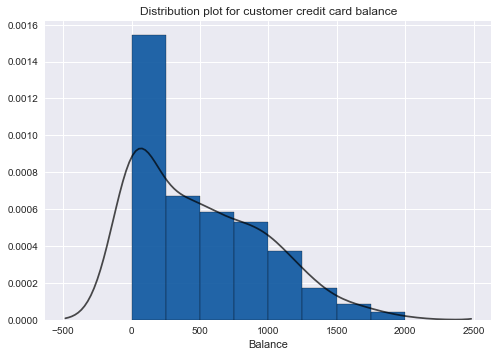

In [7]:
fig, ax= plt.subplots()
sns.distplot(train['Balance'], ax=ax, hist_kws={'alpha': 0.9, 'edgecolor':'black', 'color': blue},
             kde_kws={'color': 'black', 'alpha': 0.7})
ax.set_title('Distribution plot for customer credit card balance')
plt.show()

A scatter plot of credit limit with credit balance reveals that there is a nonlinear relatioship between these two variables. Furtheremore, there are several clients with a response value of zero, which is likely to affect model fit.

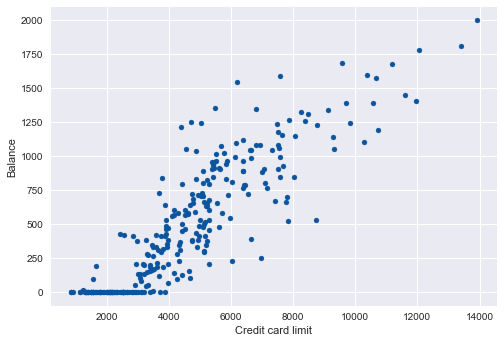

In [8]:
fig, ax= plt.subplots()
plt.scatter(train['Limit'], train['Balance'], color=blue, s=25) # the s option is the size of the dot
ax.set_xlabel('Credit card limit')
ax.set_ylabel('Balance')
plt.show()

The next cell illustrates how we can create a figure to explore the relationship between a discrete variables with not too many distinct values and the response. 

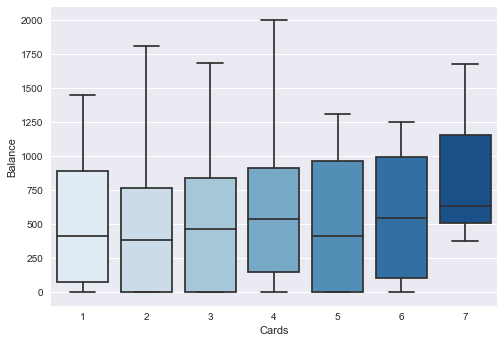

In [9]:
rows=train['Cards']<=7 # too few observations for more than 7 cards
sns.boxplot(x=train.loc[rows,'Cards'], y=train.loc[rows,'Balance'], palette='Blues')
sns.plt.show()

####**Note about plotting figures**

In general, the tutorial notebooks will provide code for figures that include customisation. This is for aesthetic reasons and to teach these details by example. It should be clear which parts are for customisation, and it is up to you to choose with a level that you are comfortable with. If you are just getting started, you may want to keep things simpler.  For example, this would be the minimal code if we just want to plot the histogram from above without worrying about details. 

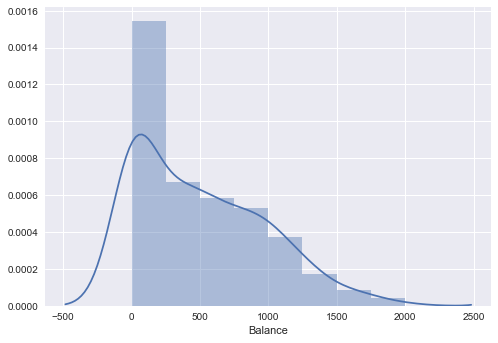

In [10]:
sns.distplot(train['Balance'])
plt.show()

As a more advanced Python note, in practice there is less repetition than what we may do in the tutorials (which is for clarity). The best practice is to create a function to automate the process of doing each type of plot in the way you prefer,  then is only a matter of reusing it. 

Here is an example. 

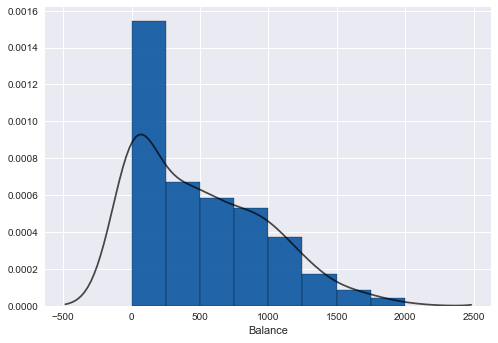

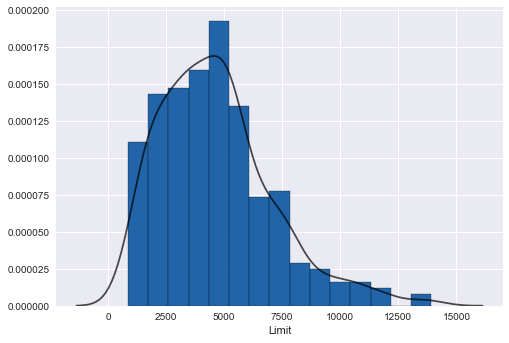

In [11]:
def hist(series):
    fig, ax= plt.subplots()
    sns.distplot(series, ax=ax, hist_kws={'alpha': 0.9, 'edgecolor':'black', 'color': blue},  
                 kde_kws={'color': 'black', 'alpha': 0.7})
    return fig, ax

hist(train['Balance'])
plt.show()

hist(train['Limit'])
plt.show()

###K-nearest neighbours

We start with a simpler setting with only one predictor, limit. Applying most of the methods in this unit follows a similar procedure: 

1. Import the method from a package.
2. Specify the model and options.
3. Fit the model.
4. Predict. 

With $k=$10 and a single predictor the first three steps are:

In [12]:
from sklearn.neighbors import KNeighborsRegressor
knn1 = KNeighborsRegressor(n_neighbors=10) #
knn1.fit(train[['Limit']], train['Balance']) # the double bracket is a technicality: we need a list of predictors

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=10, p=2,
          weights='uniform')

Suppose that we want to predict the credit card balance of a customer that has a limit of 500 thousand dollars. 

In [13]:
knn1.predict(5000)

array([ 658.7])

Let's visualise the regression fit for this model. 

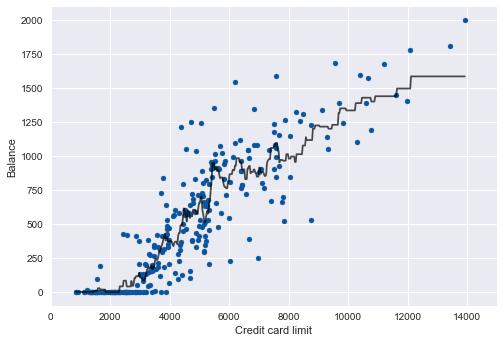

In [14]:
# Here, we generate a grid of 500 values ranging from the minimum to the maximum value of the variable in the training data
x = np.linspace(train['Limit'].min(),train['Limit'].max(), 500).reshape((-1,1))

# Compute the predicted values for each of these input points
predictions = knn1.predict(x)

# Figure
fig, ax = plt.subplots()
ax.scatter(train['Limit'], train['Balance'], color=blue, s=25) # the s option is the size of the dot
ax.set_xlabel('Credit card limit')
ax.set_ylabel('Balance')
ax.set_xlim(0, 15000)
ax.plot(x, predictions, color='black', alpha = 0.7)
plt.show()

Now that we understand how the basic process works, we can consider building upon this basic model, for example by adding other predictors. In the EDA with saw that customer income has the second strongst correlation with the response, so that a natural step would be to add it to the model. Because income and limit are on different scales, and are highly correlated, this is only going to work well if we use the [Mahalanobis distance](https://en.wikipedia.org/wiki/Mahalanobis_distance) from the slides, instead of the Euclidean distance. 

In [15]:
predictors=['Limit','Income'] # making a list to avoid retyping
knn2= KNeighborsRegressor(n_neighbors = 10 ,  metric='mahalanobis', metric_params={'V': train[predictors].cov()})
knn2.fit(train[predictors], train['Balance']) 

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='mahalanobis',
          metric_params={'V':                Limit        Income
Limit   5.935237e+06  72520.634913
Income  7.252063e+04   1332.083224},
          n_jobs=1, n_neighbors=10, p=2, weights='uniform')

###Model evaluation

We now assess the performance of our two models in the test data. 

In [16]:
from sklearn.metrics import mean_squared_error

predictions1 = knn1.predict(test[['Limit']])
mse1 = mean_squared_error(test['Balance'], predictions1)
rmse1 = np.sqrt(mse1)
print(rmse1)

236.186324047


In [17]:
predictions2 = knn2.predict(test[predictors])
mse2 = mean_squared_error(test['Balance'], predictions2)
rmse2 = np.sqrt(mse2)
print(rmse2)

163.037778086


We can then follow a similar procedure if we want to compute alternative measures. 

In [18]:
from sklearn.metrics import r2_score

rsquared1 = r2_score(test['Balance'], predictions1)
rsquared2 = r2_score(test['Balance'], predictions2)

print(rsquared1)
print(rsquared2)

0.701623223955
0.857822124887


In [19]:
from sklearn.metrics import mean_absolute_error

mae1 = mean_absolute_error(test['Balance'], predictions1)
mae2 = mean_absolute_error(test['Balance'], predictions2)

print(mae1)
print(mae2)

173.43
102.7175


Finally, we can build a table to summarise the results (for now, we are coding this with simplicity rather than efficienty in mind). 

In [20]:
results=pd.DataFrame(columns=['RMSE','R-Squared', 'MAE'], index=['KNN (one predictor)', 'KNN (two predictors)'], dtype='float64') 

results.iloc[0, 0] = rmse1
results.iloc[0, 1] = rsquared1
results.iloc[0, 2] = mae1 

results.iloc[1, 0] = rmse2
results.iloc[1, 1] = rsquared2
results.iloc[1, 2] = mae2

results.iloc[:, 0] = results.iloc[:, 0].round(0)
results.iloc[:, 1] = results.iloc[:, 1].round(2)
results.iloc[:, 2] = results.iloc[:, 2].round(0)

results

,RMSE,R-Squared,MAE
KNN (one predictor),236.0,0.70,173.0
KNN (two predictors),163.0,0.86,103.0


What are the conclusions? 

###Exercise

See the companion notebook for exercises. 